In [1]:
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
import importlib as imp
import json

import data_loader.data_loader as data_loader
from trainer.trainer import Trainer
from model.model import TorchModel
from utils import utils
import model.loss as module_loss
import model.metric as module_metric
import warnings

warnings.filterwarnings("ignore")
torch.set_warn_always(False)

# https://github.com/victoresque/pytorch-template/tree/master

In [2]:
config = utils.get_config("exp_test")

# TODO: check Shash skewness calculations...might be wrong!
# TODO: move to new project
# TODO: make data class for lats and lons

In [3]:
torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
torch.backends.cudnn.deterministic = True

# Setup the Data
trainset = data_loader.CustomData(
    config["data_loader"]["data_dir"] + "train_data.pickle"
)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "val_data.pickle")
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

# Setup the Model
model = TorchModel(config=config["arch"], target=trainset.target)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

# Visualize the model
torchinfo.summary(
    model,
    [
        trainset.input[: config["data_loader"]["batch_size"]].shape,
        trainset.input_unit[: config["data_loader"]["batch_size"]].shape,
    ],
    verbose=0,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model = model.to(device)
trainer.fit()

Epoch   0/ 5
  3.4s - train_loss: 1.35060 - val_loss: 1.21993
Epoch   1/ 5
  2.0s - train_loss: 1.31318 - val_loss: 1.21705
Epoch   2/ 5
  2.4s - train_loss: 1.40674 - val_loss: 1.21432
Epoch   3/ 5
  1.9s - train_loss: 1.33117 - val_loss: 1.21174
Epoch   4/ 5
  2.1s - train_loss: 1.37345 - val_loss: 1.20891
Epoch   5/ 5
  1.8s - train_loss: 1.33041 - val_loss: 1.20598


In [4]:
# raise ValueError()

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


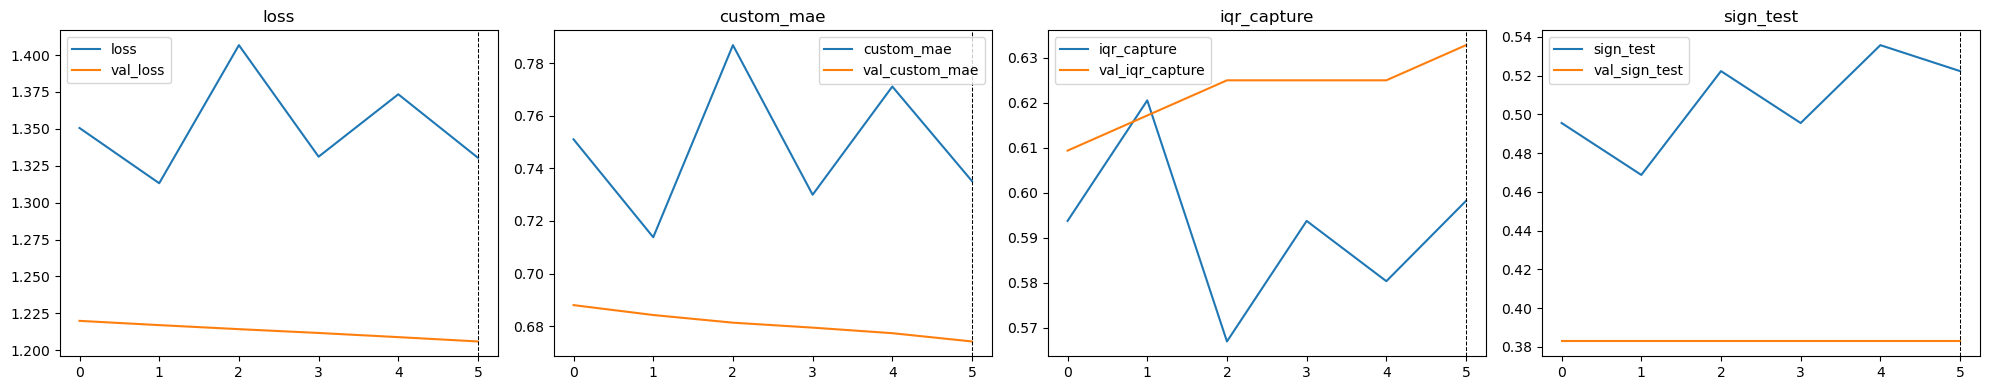

In [5]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
        x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

In [6]:
input = torch.Tensor(valset.input[:3]).to(device)
input_unit = torch.Tensor(valset.input_unit[:3]).to(device)
with torch.no_grad():
    output = model(input, input_unit)
output = output.cpu().numpy()
output

array([[ 0.9562179 ,  0.959541  , -0.20982242,  1.        ],
       [ 0.95078385,  0.9589479 , -0.20792784,  1.        ],
       [ 0.95469564,  0.9591974 , -0.20702186,  1.        ]],
      dtype=float32)

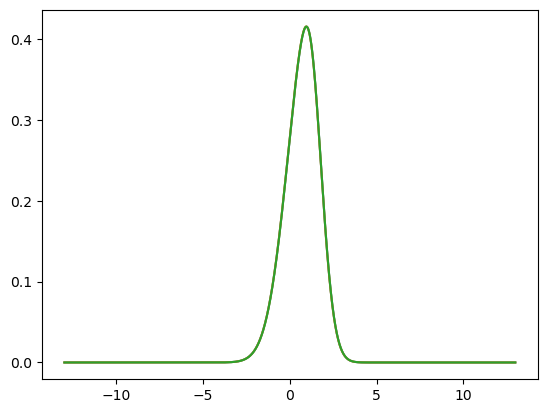

In [7]:
import shash.shash_torch
from shash.shash_torch import Shash

imp.reload(shash.shash_torch)

sample = 1
x = np.arange(-13, 13, 0.01)
dist = Shash(output)
p = dist.prob(x)

plt.plot(x, p)
plt.show()